In [1]:
### STEP NO:-01 , LOADING DATA FROM KAGLE
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 774M/778M [00:05<00:00, 159MB/s]
100% 778M/778M [00:05<00:00, 150MB/s]


### STEP NO:-02 , UNZIPPING THE FILES

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/covid19-radiography-database.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### STEP NO:-03 IMPORTING THE USEFULL LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing import image
import shutil

### STEP NO:-04 , DEFINING THE DATASET AND DELETING THE UNUSED FILES

In [ ]:
parent_folder = 'COVID-19_Radiography_Dataset'
child_folders = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

In [6]:
key = "/masks"
for folder in [parent_folder+"/"+i+key for i in child_folders]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Deleted folder: {folder}")
    else:
        print(f"Folder not found: {folder}")

Deleted folder: COVID-19_Radiography_Dataset/COVID/masks
Deleted folder: COVID-19_Radiography_Dataset/Lung_Opacity/masks
Deleted folder: COVID-19_Radiography_Dataset/Normal/masks
Deleted folder: COVID-19_Radiography_Dataset/Viral Pneumonia/masks


### STEP NO:-05 , DATA PRE-PROCESSING

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    parent_folder,
    labels='inferred',
    label_mode='categorical',
    batch_size=32
)

Found 21165 files belonging to 4 classes.


In [8]:
for images, labels in dataset:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Labels:", labels)

Streaming output truncated to the last 5000 lines.
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]], shape=(32, 4), dtype=float32)
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 4)
Labels: tf.Tensor(
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]], shape=(32, 4), dtype=float32)
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 4)
Labels: tf.Tensor(
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]

In [9]:
class_label_idx = np.argmax(labels,1)
class_label_idx

array([2, 3, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1])

In [10]:
class_names = dataset.class_names

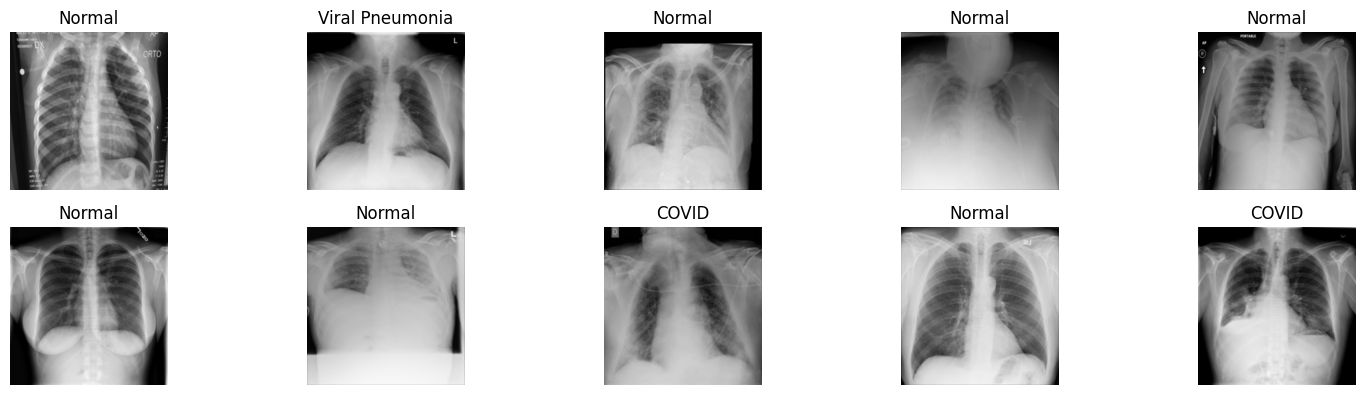

In [11]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(15, 6))
    for i in range(10):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[class_label_idx[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### STEP NO:-06 , Define the dataset directory

In [29]:
dataset_dir = '/content/COVID-19_Radiography_Dataset'

# Create the training dataset with 80% of the data
train_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.20,
    subset='training',
    seed=123
)
# Create the validation dataset with 20% of the data
validation_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [30]:
import tensorflow_datasets as tfds

batch_size=32

dataset_name=dataset
class_names=dataset.class_names
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [31]:
# Extract labels and images from the dataset
for images, labels in train_ds:
    # You can use these labels for train_test_split
    print(labels)
    break

tf.Tensor([0 2 1 0 0 2 2 2 2 2 0 1 0 2 2 1 2 2 2 2 2 2 3 0 2 1 2 1 3 2 0 1], shape=(32,), dtype=int32)


### STEP NO:-07 , NORMALIZE

In [32]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

### STEP NO-08 , SAMPLING

In [35]:
# Now you can use the labels variable in train_test_split
X_train, X_test, y_train, y_test = train_test_split(images.numpy(), labels.numpy(), test_size=0.20, random_state=42)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25, 256, 256, 3), (7, 256, 256, 3), (25,), (7,))

In [37]:
# Only apply to_categorical once
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

### STEP NO-09 , MODEL FITTIG

In [38]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(4,4), activation='relu', input_shape=(256,256,3)))
model.add(Conv2D(128, (4,4), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (4,4), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (4,4), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 253, 253, 32)      1568      
                                                                 
 conv2d_5 (Conv2D)           (None, 250, 250, 128)     65664     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 125, 125, 128)     0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 125, 125, 128)     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 122, 122, 64)      131136    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                 

In [41]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=15,  batch_size=32)

Epoch 1/15
1/1 [==============================] - 28s 28s/step - loss: 14.3405 - accuracy: 0.3500 - val_loss: 107.5043 - val_accuracy: 0.2000
Epoch 2/15
1/1 [==============================] - 26s 26s/step - loss: 165.1481 - accuracy: 0.3500 - val_loss: 22.3274 - val_accuracy: 0.6000
Epoch 3/15
1/1 [==============================] - 23s 23s/step - loss: 105.3434 - accuracy: 0.4000 - val_loss: 15.2728 - val_accuracy: 0.6000
Epoch 4/15
1/1 [==============================] - 25s 25s/step - loss: 63.8153 - accuracy: 0.3500 - val_loss: 3.7825 - val_accuracy: 0.6000
Epoch 5/15
1/1 [==============================] - 27s 27s/step - loss: 23.4655 - accuracy: 0.3500 - val_loss: 3.6094 - val_accuracy: 0.6000
Epoch 6/15
1/1 [==============================] - 23s 23s/step - loss: 8.3291 - accuracy: 0.3000 - val_loss: 1.9726 - val_accuracy: 0.2000
Epoch 7/15
1/1 [==============================] - 25s 25s/step - loss: 3.9086 - accuracy: 0.4500 - val_loss: 2.6265 - val_accuracy: 0.2000
Epoch 8/15
1/1 [

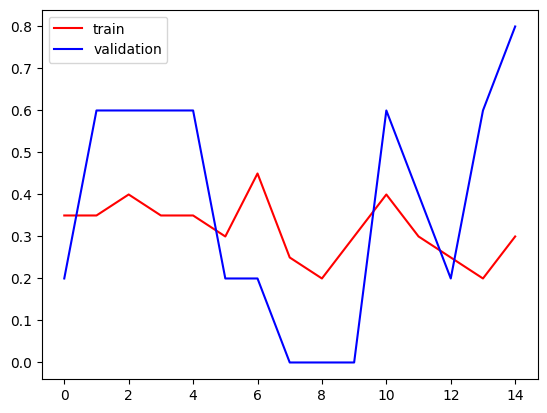

In [42]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

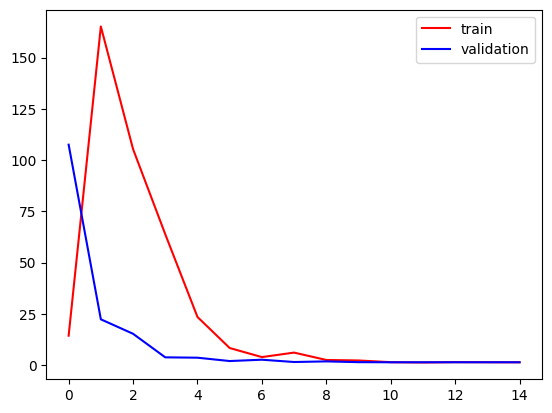

In [43]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [44]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

1/1 [==============================] - 2s 2s/step


In [45]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test = np.argmax(y_test, axis = 1)

1/1 [==============================] - 2s 2s/step


In [46]:
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [47]:
# Check the unique values in y_test_new and y_pred to confirm if all classes are present
print(np.unique(y_test))
print(np.unique(y_pred))

[0 1 2]
[0 1 2]


In [48]:
import cv2

In [49]:
test_img = cv2.imread('/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png')

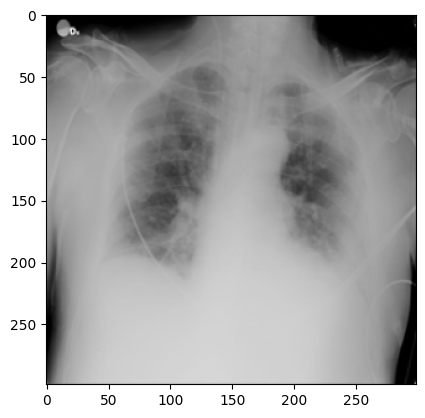

In [50]:
plt.imshow(test_img)

In [51]:
test_img.shape

(299, 299, 3)

In [52]:
test_img = cv2.resize(test_img,(256,256))

In [53]:
test_input = test_img.reshape((1,256,256,3))

In [54]:
model.predict(test_input)

1/1 [==============================] - 0s 347ms/step


array([[0.25157762, 0.25124016, 0.24881546, 0.24836673]], dtype=float32)

In [ ]:
CONCLUSION:-The model is a ideal model, performing well on predicting   classes 0, 1 & 2.
The model predict COVID-19_Radiography_Dataset/COVID/images/COVID-1.png perfectly as 0.2515 = 25.15% i,e. category "1" ,
which detects the give x-ray data set is "COVID" . 

****************************************************DONE****************************************************